### Atoms and the structures they make


Protein design is an active field of research right now. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "protein.jpg", width = 400, height = 400)


The image is from Pan and Kortemme, Journal of Biological Chemistry 296 (2021) where they discuss strategies to design proteins.

Designing proteins and things at that tiny scale depends a lot of what shapes atoms like to follow. Typically, atoms form shapes by minimizing some potential.  This notebook finds a configuration of atoms that minimize the Lennard-Jones potential and visualizes it.

The Lennard-Jones potential for two atoms is given by

$V(r) = 4 \mathcal{E} \big[\big(\frac{\sigma}{r}\big)^{12}-\big(\frac{\sigma}{r}\big)^{6}\big]$

where $\mathcal{E}$ is the dispersion energy, $\sigma$ is the 'size' of the atom and $r$ is the distance between atoms

#### Lennard-Jones Configurations of Atoms

In [1]:
import numpy as np
from scipy.spatial.distance import pdist,cdist
from scipy.optimize import fmin_tnc as tnc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D
import random

Ndim = 3
def LJ(locations, dim = Ndim):
    'Computes the Lennard-Jones potential given the location of atoms'
    A = 1
    B = 1
    locations = locations.reshape(-1,dim)

    pairwise_distances = pdist(locations)
    #print(locations)
    ans  = 0
    for r in pairwise_distances:
        if r == 0:
            print('two atoms are at same location.')
        else:
            ans += A/r**12-B/r**6
    return ans

def LJ_derivative(locations, dim = Ndim):
    'Computes the gradient of the Lennard-Jones potential given the location of atoms'
    A = 1
    B = 1

    locations = locations.reshape(-1,dim)
    N_atoms = len(locations)
    grad = np.zeros((N_atoms,dim))
    for i in range(1,N_atoms):
        for j in range(N_atoms):
            if i != j:
                r  = np.linalg.norm(locations[i,:]-locations[j,:])
                grad[i,:] += -(12*A/r**14-6*B/r**8)*(locations[i,:]-locations[j,:])
    if dim >1:
        grad[1,1:] =  grad[0,1:]
    if dim >2 and N_atoms >2:
        grad[2,2:] =  grad[0,2:]
    #print(grad)
    return grad.flatten()

xvalues = np.linspace(0.89,3,100)

if Ndim ==1:
    locationlist = [np.array([0,x]) for x in xvalues]
elif Ndim ==3:
    locationlist = [np.array([0,0,0,x,0,0]) for x in xvalues]
LJvalues = [LJ(location) for location in locationlist]

def getNDpoint(x0,dim = Ndim):
    point = [random.uniform(0,1.5),random.uniform(0,1.5),random.uniform(0,1.5)]
    if min(cdist(x0,[point])) < 0.01:
        return getNDpoint(x0,dim)
    else:
        return point
    

def create_x0(N,dim = Ndim):
    'creates initial guess'
    x0 = np.zeros((N,dim))
    if N == 2:
        x0[1,0]=random.uniform(0,1.5)
        return x0
    x0[1,:] = [0.8,0,0]
    x0[2,:] = [0.3,0.4,0]
    for i in range(3,N):
        x0[i,:] = getNDpoint(x0,dim)
    return x0

def sequence(N):
    'Takes the number of atoms, creates initial guess and uses truncated Newton to find a LJ minima'
    x0 = create_x0(N)
    w = tnc(LJ,x0, fprime = LJ_derivative)
    w_r = w[0].reshape(-1,Ndim)
    #w_r = np.round(w_r, 6)
    return w_r

In [2]:
%matplotlib notebook

In the following block, we plot the configuration obtained using N_atoms and the energy of the configuration. This can be compared against the global minima here (http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html)

The energy is  -179.9218642613748


<IPython.core.display.Javascript object>


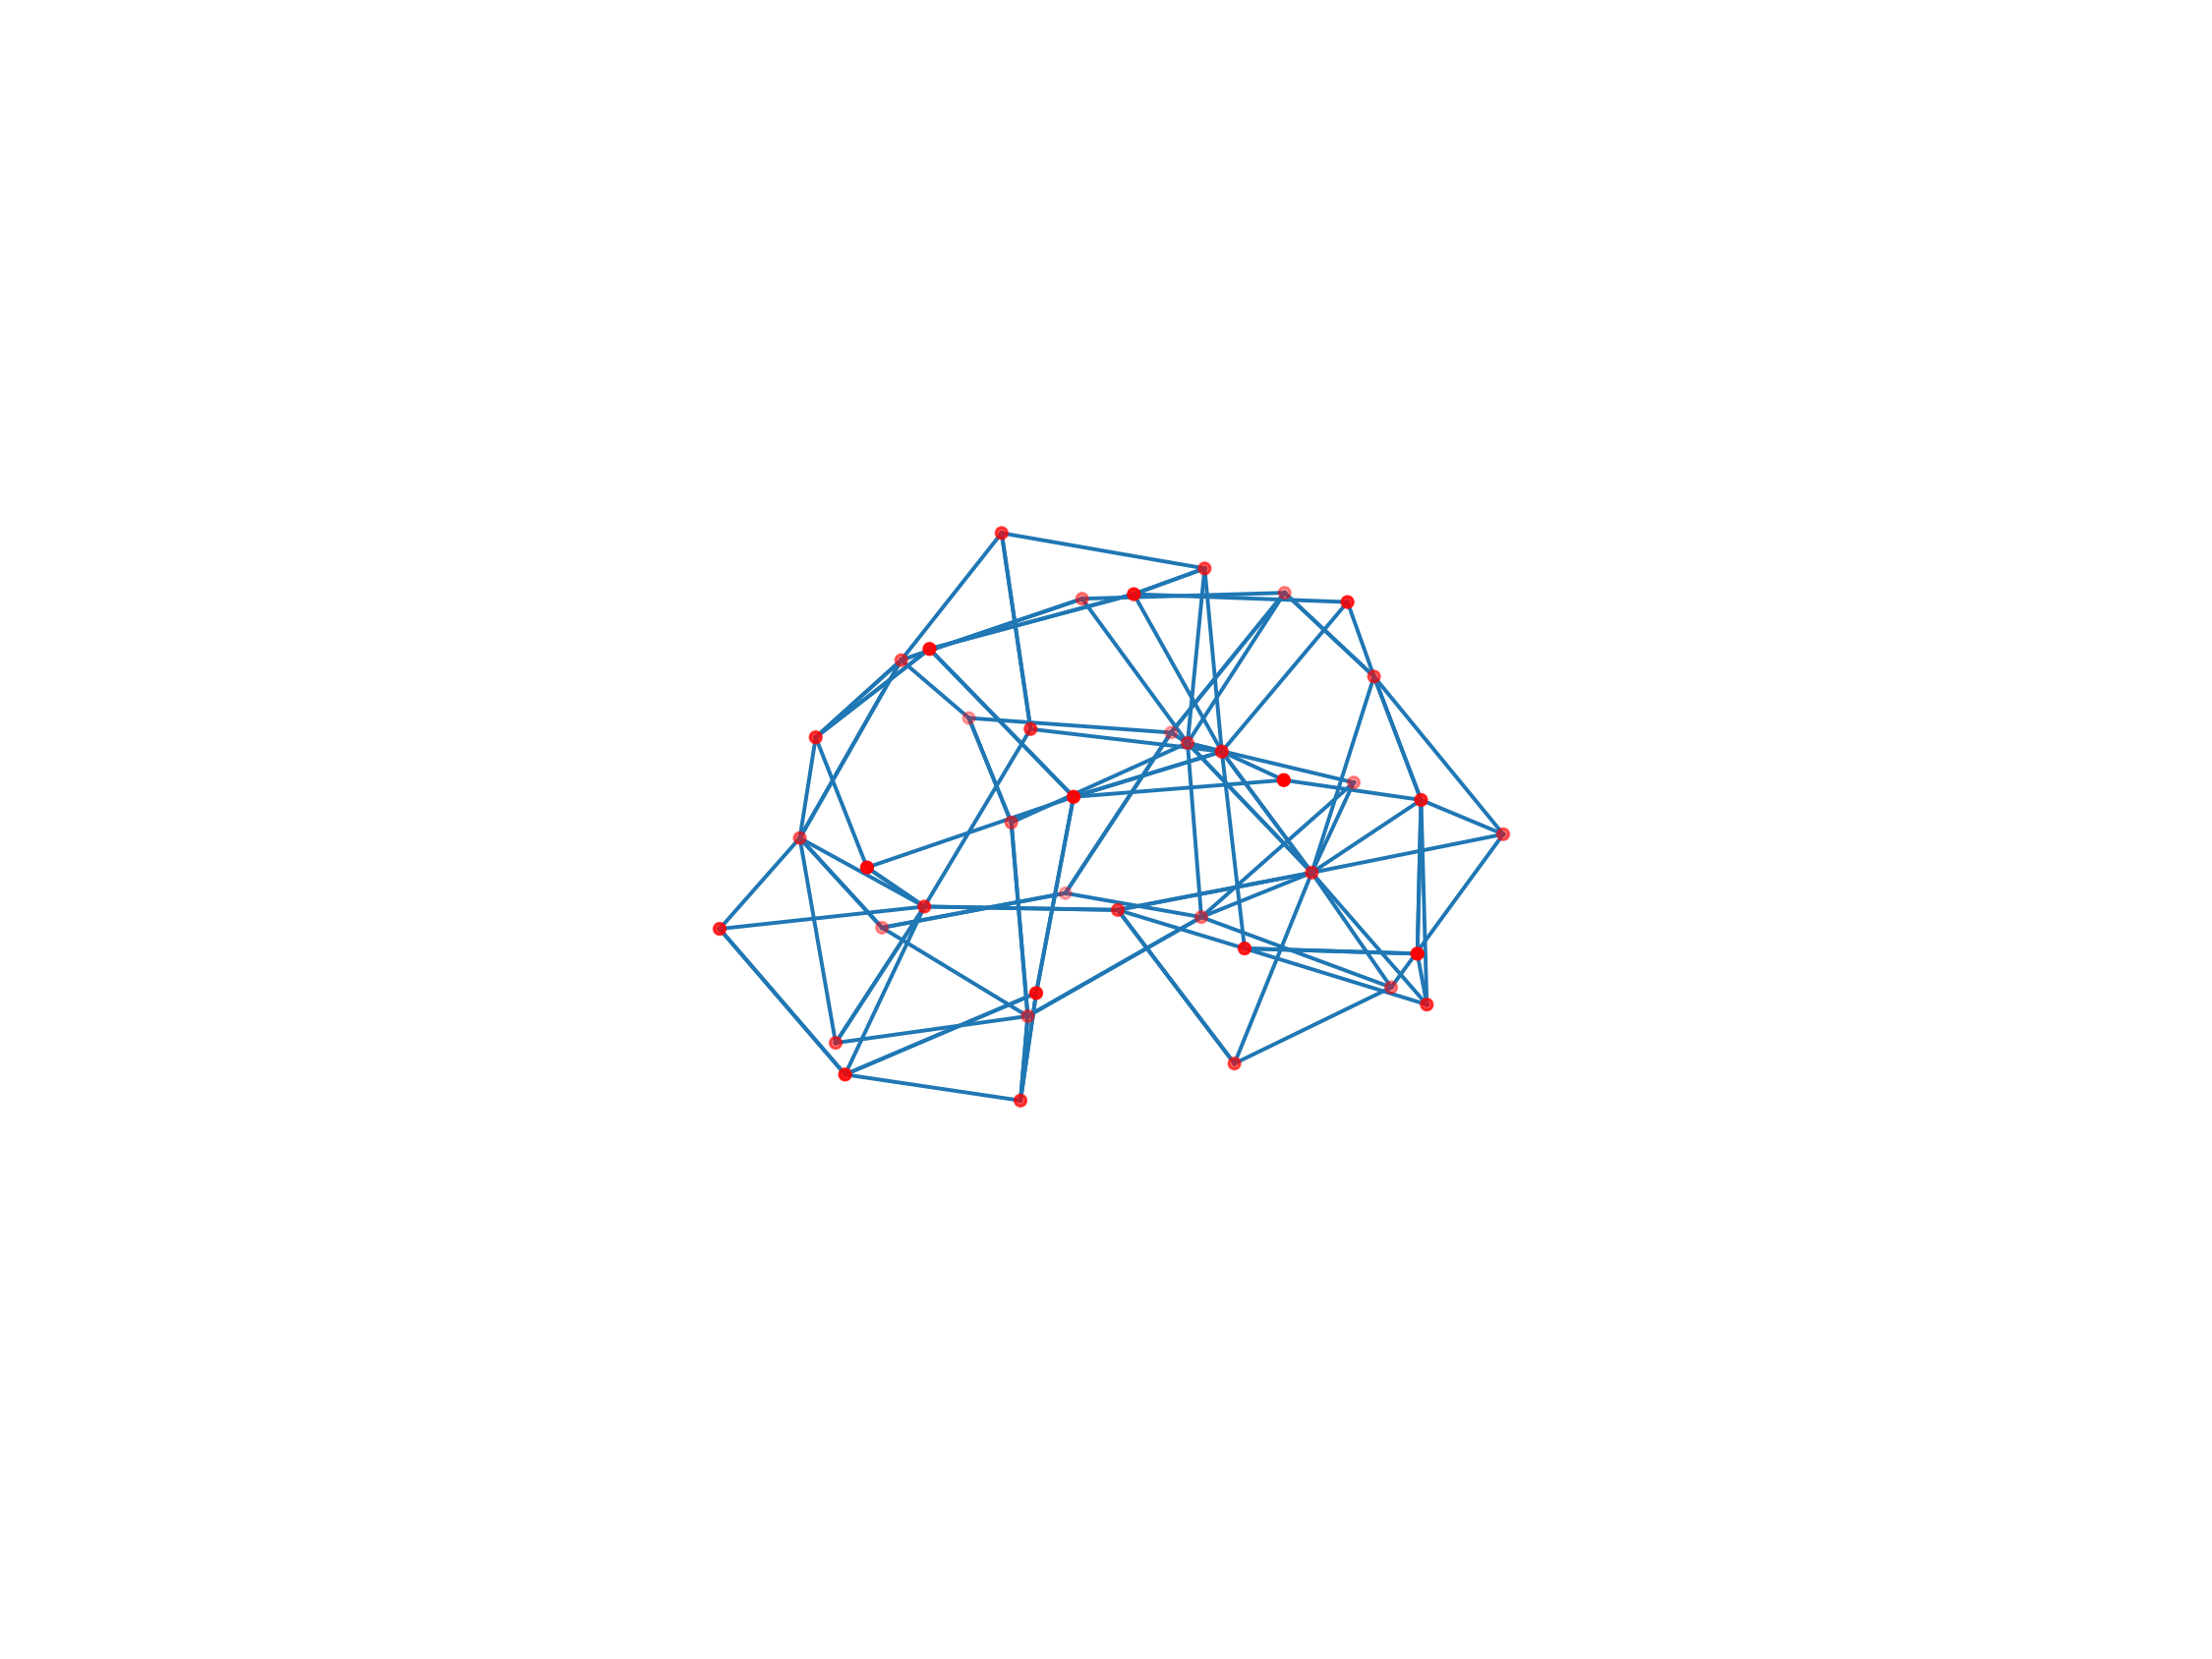

In [4]:
N_atoms = 40
w_r = sequence(N_atoms)
x = w_r[:,0]
y = w_r[:,1]
z = w_r[:,2]
print('The energy is  '+ str(4*LJ(w_r.flatten())))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x, y, z,color ='r',s=20)
from scipy.spatial import distance
D = distance.squareform(distance.pdist(w_r))
D  = np.round(D, 3)
closest = np.argsort(D, axis=1)
k=4
for i in range(len(w_r)):
    point = w_r[i]
    for j in range(k):
        nn = w_r[closest[i,j]]
        #print(nn)
        line = Line3D([point[0],nn[0]], [point[1],nn[1]], [point[2],nn[2]])
        ax.add_line(line)
ax.axis('off')
plt.savefig('7atoms.pdf')

#### How does one speed up this process?

For that, you can read my paper 

George, Jithin, and Zichao Di. "Trilateration-Based Multilevel Method for Minimizing the Lennard-Jones Potential." Computational Science–ICCS 2020: 20th International Conference, Amsterdam, The Netherlands, June 3–5, 2020, Proceedings, Part V 20. Springer International Publishing, 2020.

https://link.springer.com/chapter/10.1007/978-3-030-50426-7_13